# Contagion Models and the Prediction of Legisign Replication

Today, we're going to learn how to run both simple and complex contagion simulations using Python's [NDLib](https://ndlib.readthedocs.io/en/latest/reference/reference.html) (Network Diffusion Library) package, as well as plot the results of these simulations.

Once we're comfortable with NDLib, we're going to use these methods to predict the increase and decrease in legisign replication of a social media trend (the "Tide Pod Challenge") using the "Kiki Challenge" trend to fit our model. We'll be using Google Trends data as our source of data to try to get after cross-platform social media interest across the Internet.

To install NDLib, run the following command on your terminal/command line:

`pip install ndlib`

Or, in your Jupyter notebook, you can run it like so (Warning: it can take a while to download/install):

In [1]:
# !pip install ndlib

If you're using a Windows computer, you may need to download the file for the python-igraph package from [here](https://www.lfd.uci.edu/~gohlke/pythonlibs/#python-igraph) to successfully install the python-igraph package. The number after 'win' in the file name refers to whether you have a 32-bit or 64-bit Operating System (you can check this in your system settings in the "About" section. The number after 'cp' in the file name refers to your version of Python (3.7, 3.8, etc.), which you can figure out by running the command:

In [3]:
!python --version

Python 3.7.3


Once you have downloaded the correct file, put it in your local directory (or navigate to the file via the command line), and then run the command `pip install file_name`, replacing `file_name` with the name of the file that you downloaded. You should then be able to install NDLib as well via the aforementioned command `pip install ndlib`.

Now that we have all of our packages installed, let's import what we need into this session and then get started!

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs
import ndlib.models.CompositeModel as gc
from ndlib.models.compartments import NodeThreshold
from ndlib.models.compartments import NodeStochastic
from scipy.optimize import minimize
import numpy as np
import seaborn as sns
import pandas as pd

# Function simulates model given parameters and gives us y_forecasted below (mean trend)
def simulate_net_diffusion(frac_infected = 0.01 ,threshold = 0.18, profile = 0.00001, p_removal = 0.017, num_exec = 10, num_iter=100, nproc=8):
    # Network generation
    g = nx.erdos_renyi_graph(1000, 0.1)
    
    # Composite Model instantiation
    sir_th_model = gc.CompositeModel(g)

    # Model statuses
    sir_th_model.add_status("Susceptible")
    sir_th_model.add_status("Infected")
    sir_th_model.add_status("Removed")

    # Compartment definition
    c1 = NodeThreshold(threshold=None, triggering_status="Infected")
    c2 = NodeStochastic(p_removal)

    # Rule definition
    sir_th_model.add_rule("Susceptible", "Infected", c1)
    sir_th_model.add_rule("Infected", "Removed", c2)

    # Model initial status configuration
    config = mc.Configuration()
    config.add_model_parameter('fraction_infected', frac_infected)

    # Setting nodes parameters
    for i in g.nodes():
        config.add_node_configuration("threshold", i, threshold)
        config.add_node_configuration("profile", i, profile)

    # Simulation execution
    sir_th_model.set_initial_status(config)
    trends = multi_runs(sir_th_model, execution_number=num_exec, iteration_number=num_iter, nprocesses=nproc)
    
    # convert into a dataframe that lists each number of infected nodes by iteration number (to make average calculation)
    df_infected = pd.DataFrame([execution['trends']['node_count'][1] for execution in trends])
    
    # Normalize each run:
    df_infected = df_infected.apply(lambda x: x/x.max(), axis=1)
    df_infected = pd.melt(df_infected, var_name='Execution', value_name='Infected')
    
    # Normalize (mean) values so that they are consistent with Google Trends Data for comparison:
    y_forecasted = df_infected.groupby('Execution').mean()* 100
    
    return y_forecasted

# Function returns results from all simulated runs for plotting 95% Confidence Intervals of Predictions
def full_simulate_net_diffusion(frac_infected = 0.01 ,threshold = 0.18, profile = 0.00001, p_removal = 0.017, num_exec = 10, num_iter=100, nproc=8):
    # Network generation
    g = nx.erdos_renyi_graph(1000, 0.1)
    
    # Composite Model instantiation
    sir_th_model = gc.CompositeModel(g)

    # Model statuses
    sir_th_model.add_status("Susceptible")
    sir_th_model.add_status("Infected")
    sir_th_model.add_status("Removed")

    # Compartment definition
    c1 = NodeThreshold(threshold=None, triggering_status="Infected")
    c2 = NodeStochastic(p_removal)

    # Rule definition
    sir_th_model.add_rule("Susceptible", "Infected", c1)
    sir_th_model.add_rule("Infected", "Removed", c2)

    # Model initial status configuration, assume 1% of population is infected
    config = mc.Configuration()
    config.add_model_parameter('fraction_infected', frac_infected)

    # Setting nodes parameters
    for i in g.nodes():
        config.add_node_configuration("threshold", i, threshold)
        config.add_node_configuration("profile", i, profile)

    # Simulation execution
    sir_th_model.set_initial_status(config)
    trends = multi_runs(sir_th_model, execution_number=num_exec, iteration_number=num_iter, nprocesses=nproc)
    
    # Convert into a dataframe that lists each number of infected nodes by iteration number (to make average calculation)
    df_infected = pd.DataFrame([execution['trends']['node_count'][1] for execution in trends])
    
    # Normalize each run, so that they are consistent with Google Trends Data for comparison:
    df_infected = df_infected.apply(lambda x: x/x.max(), axis=1)
    df_infected = pd.melt(df_infected, var_name='Execution', value_name='Infected')
    df_infected['Infected'] *= 100
    
    return df_infected

def mse(params, y_actual, time_steps):
    # Returns Mean Squared Error of the forecasted values, in comparison to actual values, for given parameters
    y_forecasted = simulate_net_diffusion(threshold=params[0], profile=params[1], p_removal=params[2], num_iter=time_steps)['Infected']
    y_forecasted.index = y_actual.index
    
    mse = ((y_forecasted - y_actual) ** 2).mean()
    return np.float(mse)

def optimize_net_diffusion_model(y_actual, time_steps, maxiter=1, params=[0.18, 0.00001, 0.017]):
    # Parameters to optimize; passing in initial parameter values as a starting "guess": threshold, profile, p_removal
    x0 = np.array(params)
        
    # Find parameters that minimize Mean Squared Error
    result = minimize(mse, x0 , args=(y_actual, time_steps), method='nelder-mead', options={'xtol': 1e-8, 'maxiter': maxiter, 'disp': True})
    
    return result

**********************

Let's first start with a simple contagion model. Here, nodes in a network switch from Susceptible -> Infected with a certain probability "beta" if they come in contact with an infected node. To perform a simulation, we need to first generate a random graph (i.e. a network) over which our contagion can spread, since we do not have an empirical one that we can use. To do this, we use the NetworkX package to generate a erdos_renyi random graph, which you can read more about in the [documentation on NetworkX](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html).

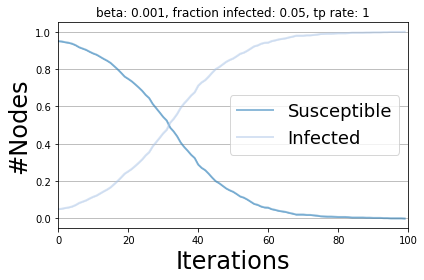

In [4]:
# Network generation
g = nx.erdos_renyi_graph(1000, 0.1)

# SI
si_model = ep.SIModel(g)
config = mc.Configuration()

# Nodes switch from S->I with probability .001 when they come in contact with an infected node:
config.add_model_parameter('beta', 0.001)

# Arbitrarily set the fraction of initially infected nodes in the network to 5%
config.add_model_parameter("fraction_infected", 0.05)
si_model.set_initial_status(config)

# Execute simulation over 100 iterations/time steps and build a trend line describing the # of infected nodes at each step:
iterations = si_model.iteration_bunch(100)
trends0 = si_model.build_trends(iterations)

# Visualize the shift of Nodes from Susceptible -> Infected in the network
viz = DiffusionTrend(si_model, trends0)
viz.plot()

We can see that the simple contagion gradually infects the entire population by around time-step 30, and then slows down around time step 40 before infecting the entire population around time step 80. Based on our readings, simple contagion models seem to best model the replication of legisigns that are relatively low barrier to entry and are low risk to social/cultural capital, such as liking a cat video or retweeting news form the mass media.

These simple contagion models do not seem to effectively model higher risk cultural diffusion, though, where there might be some risk to an individual node's social/cultural capital and the legisigns might be more difficult for the individual to replicate than clicking "like." Some examples of these types of phenomena are the use of charged political hashtags and posting videos of yourself completing the ALS Ice Bucket Challenge (pouring a bucket of ice over your head).

To better model the replication of these more difficult-to-replicate legisigns, we can model the effect of a "complex contagion" on our same network. First, let's use the classic threshold model introduced by Granovetter in 1978 that we read about in our readings for this week. In this type of model, a node will become infected based on the percentage of its neighbors that have become infected. If the percentage of its infected neighbors goes over a certain threshold, the node will become infected. You can read more about the model and the specific implementation we are using in the [NDLib documentation](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Threshold.html).

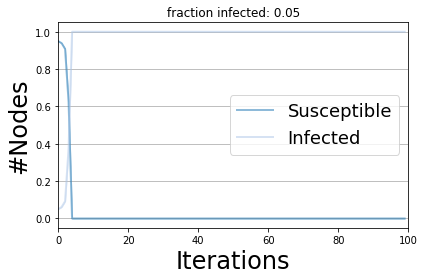

In [4]:
# Attach Threshold model to Random Graph defined earlier
th_model = ep.ThresholdModel(g)
config = mc.Configuration()

# Set individual node thresholds arbitrarily to 10%; can add individual probability thresholds if desired
threshold = 0.1
for n in g.nodes():
        config.add_node_configuration("threshold", n, threshold)

# Arbitrarily set the fraction of infected individuals at the outset of the simulation to 5%
config.add_model_parameter("fraction_infected", 0.05)
th_model.set_initial_status(config)

# Run the simulation for 100 time-steps and build a trend line
iterations = th_model.iteration_bunch(100)
trends1 = th_model.build_trends(iterations)

# Visualize the results
viz = DiffusionTrend(th_model, trends1)
viz.plot()

We can see that this complex contagion infects our network much more rapidly. 

We can also model such complex contagions in a way closer to what we read about in our readings, where after a node goes above a certain threshold, it does not automatically become infected. Instead, the node has a slightly more active role in "choosing" to be infected, modeled as the probability of being infected after the node has crossed the threshold for infection. One such approach is called a "Profile Threshold" model, which you can read more about in the [NDLib documentation](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/ProfileThreshold.html#id2) as well as in the [original paper](https://link.springer.com/article/10.1007/s41109-018-0100-5) introducing the approach.

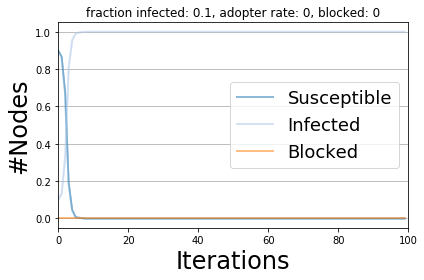

In [6]:
# Attach Profile Threshold Model to Random Graph:  
pth_model = ep.ProfileThresholdModel(g)
config = mc.Configuration()

# Set initially infected to 10%; at 5% the infection does not spread
config.add_model_parameter('fraction_infected', 0.1)

# Setting nodes parameters
threshold = 0.15
profile = 0.25 # probability of being "infected" after crossing threshold
for i in g.nodes():
    config.add_node_configuration("threshold", i, threshold)
    config.add_node_configuration("profile", i, profile)

pth_model.set_initial_status(config)

# Simulation execution
iterations = pth_model.iteration_bunch(100)
trends2 = pth_model.build_trends(iterations)

viz = DiffusionTrend(pth_model, trends2)
viz.plot()

In this approach, we can see that given the parameters supplied, the infection only spreads when the intial percentage infected is larger than 5%. So, supplying nodes with some agency moderates the spread of the contagion to some degree.

In the Sprage and House study we read for this week, they added an additional parameter that would "remove" nodes from "infected" status with a certain probability. This allows us to not just model the increase in replication of a particular legisign, but also the decrease--potentially identifying specific timing for the rise and fall of legisign replication. We can supply the same logic that they did by constructing a custom NDLib composite model.

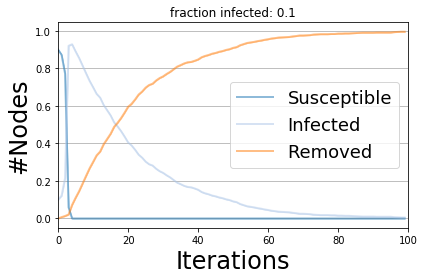

In [7]:
# Attach Composite Model to Random Graph
sir_th_model = gc.CompositeModel(g)

# Explicitly Specify Model statuses to custom composite model
sir_th_model.add_status("Susceptible")
sir_th_model.add_status("Infected")
sir_th_model.add_status("Removed")

# Define the probabilities by which statuses change:
c1 = NodeThreshold(threshold=None, triggering_status="Infected")
c2 = NodeStochastic(0.05)

# Rule definition for moving between statuses/compartments
sir_th_model.add_rule("Susceptible", "Infected", c1)
sir_th_model.add_rule("Infected", "Removed", c2)

# Model initial status configuration
config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.1)

# Setting node parameters
threshold = 0.15
profile = 0.1 # probability of being "infected" after crossing threshold
for i in g.nodes():
    config.add_node_configuration("threshold", i, threshold)
    config.add_node_configuration("profile", i, profile)
    
sir_th_model.set_initial_status(config)

# Simulation execution for 100 time steps
iterations = sir_th_model.iteration_bunch(100)
trends = sir_th_model.build_trends(iterations)

# Visualize:
viz = DiffusionTrend(sir_th_model, trends)
viz.plot()

We can see that modeling the phenomenon in this way additionally produced a decline in infection after the peak, a useful way to model the rise and fall of a particular phenomenon. 

Up until this point, we have only been running single simulations. This is useful for quick visualizations, but does not tell us anything about the general pattern of simulation. In the Sprague and House article for instance, they produced confidence intervals around their predictions. Using a simulation approach, we can similarly identify the distribution around our estimates by running our simulation multiple times and then plotting the 95% Confidence Interval Band around our mean trend line. This can be useful of identifying whether an empirical phenomenon overlaps with our simulated predictions. Let's try producing bands around our estimates for the `si_model` above:

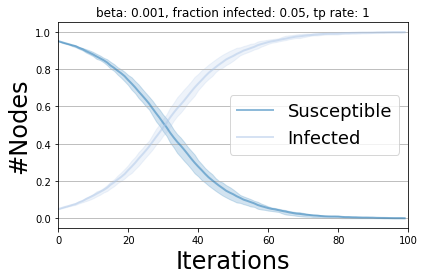

In [12]:
# Execute the simulation multiple times with the maximum number of processors available on your computer
trends = multi_runs(si_model, execution_number=5, iteration_number=100)
viz = DiffusionTrend(si_model, trends)
viz.plot(percentile=.95)

We can see that there are faint bands around our mean trend lines that tell us how the distribution of simulations is behaving more generally.

## Predicting the Rise and Fall of Social Media Legisign Replication

Let's say we want to use these models to actually predict the legisign replication pattern of some cultural trend -- say the [Tide Pod Challenge of early 2018](https://www.reddit.com/r/intrusivethoughts/comments/6mh9x2/bite_into_one_of_those_tide_pods_do_it/). Based on the theories of contagion that we read about in class on Tuesday, we should likely choose a complex contagion model to predict this adoption pattern (as it requires a more difficult task than simply retweeting, or pressing a button -- i.e. actually ingesting poison). The question remains, though, how we will optimize our parameters to predict this cultural trend as accurately as possible.

There are many considerations to take into account when performing optimization routines and making predictions (which you can learn about in Machine Learning, Large-scale computing, and Optimization courses). For this class, however, we will simply fit a number of different parameter combinations to optimally model one other cultural trend to demonstrate the general pipeline for this kind of approach. 

We'll be focusing on the [Kiki Challenge](https://www.youtube.com/watch?v=5KljQ2iGSX8) for this parameter tuning step of our prediction ([also involving dangerous and difficult behavior](https://www.theguardian.com/music/2018/jul/30/kiki-keke-challenge-drake-police-warn-dangerous-viral-dance): commonly, jumping outside of a moving car and dancing alongside the car while it is moving). We will then choose the parameters values that produce an infection trend closest to the true trend, as defined by Google Trends (both of these trends were widely shared on social media and then searched for on Google in tandemn, making Google Trends a great source to work with, since it helps us better understand the zeitgeist surrounding the overall social media ecosystem in the US). We'll then use these parameters that we optimized for the Kiki Challenge to predict the Tide Pod challenge trend before it takes off. Essentially, what we're doing is creating a model to explain legisign replication for the Kiki Challenge and then, recognizing that the Tide Pod Challenge is similar in certain ways, using our model to predict the rise and fall of the replication of that challenge's legisign as well.

If we take a look at [Google Trends](https://trends.google.com/trends/explore?q=kiki%20challenge&date=today%205-y&geo=US), we can see that the Kiki Challenge was definitely a legisign within the USA. Its object of the "Kiki Challenge" is a particular dance centered around a Drake song (as evidenced by related topics like "Drake" and "Will Smith" via the YouTube video linked above) and this is a conventional association, recognized as "trend" by Google during the height of the challenge. Furthermore, there seems to be a common interpretant with people also searching for "Drake", "Car," and "Dance" as related queries, associating the "Kiki Challenge" with this particular dance and set of practices that are deemed to be dangerous in a potentially dicentic way (see "Death" as a related topic). In our prediction, we will have to also predict that the "Tide Pod Challenge" will have a consistent sign relationship through time as well (i.e. it won't take on different meanings at different times).

To fit our Kiki Model and evaluate its predictive accuracy in predicting the Tide Pod Challenge Trend, we will take data from Google Trends at the first evidence of an up-tick (i.e. 1% of the total 100% popularity of the topic) for both of the phenomena (i.e. centering the analysis at an inflection point), meant to predict when the magnitude of the cultural trend would be at its greatest and when the trend would die down again.

In [13]:
# Read in data from Google Trends related to Kiki Challenge and start at first evidence of an uptick in interest
kiki_challenge = pd.read_csv('kiki_challenge_trend.csv')
kiki_challenge = kiki_challenge.loc['2018-07-01':'2019-02-03']

# Rename column and convert magnitudes to numerical values (with values '<1' being converted to 1)
kiki_challenge.columns = ['num_infected']
kiki_challenge = pd.to_numeric(kiki_challenge['num_infected'].str.strip("<"))

Let's identify the optimal parameters for a complex contagion model to fit the Kiki Challenge Data. Note: running the code for 1000 sets of parameter combinations was not enough to converge on an optimal solution. It took a very long time to run, though, so we will proceed with the best model from this set of 1000 iterations. To converge on an optimal solution, we would ideally use large-scale computing methods to converge on a solution faster.

In [9]:
# WARNING: takes a long time to run (and does not converge on optimal solution in only 1000 iterations)
# result = optimize_net_diffusion_model(y_actual=kiki_challenge, time_steps=32, maxiter=1000)

In [27]:
simulated_results_kiki = full_simulate_net_diffusion(frac_infected = 0.01,
                                                     threshold = 0.038, 
                                                     profile = 0.0000105, 
                                                     p_removal = 0.22,
                                                     num_iter=32,
                                                     num_exec=20
                                                   )

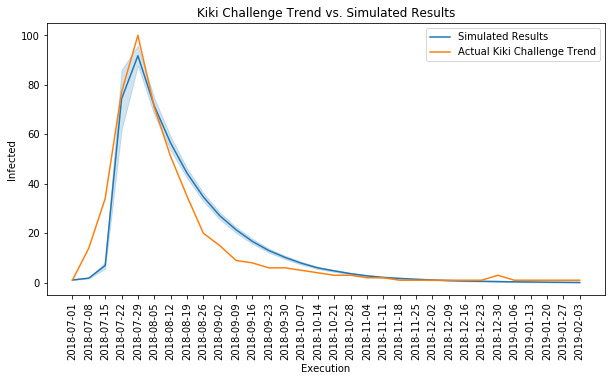

In [28]:
# Plot simulated results vs. actual Kiki Challenge Trend:
plt.figure(figsize=(10,5))

# Seaborn lineplot automatically plots 95% confidence interval around the mean trend line
sns.lineplot(x='Execution', y='Infected', data=simulated_results_kiki, label='Simulated Results')

# Superimpose Kiki Challenge data on the same plot to compare the results:
plt.plot(kiki_challenge, label='Actual Kiki Challenge Trend')
plt.xticks(rotation=90)
plt.title('Kiki Challenge Trend vs. Simulated Results')
plt.legend();

Let's now use this model to try to predict the rise and fall of the [Tide Pod Challenge trend](https://trends.google.com/trends/explore?date=today%205-y&geo=US&q=Tide%20Pod%20Challenge).

In [19]:
# Read in data from Google Trends related to Tide Pod Challenge and start at first evidence of an uptick in interest
tide_pod_challenge = pd.read_csv('tide_pod_challenge_trend.csv')
tide_pod_challenge = tide_pod_challenge.loc['2017-12-17':'2018-07-22']

# Rename column and convert magnitudes to numerical values (with values '<1' being converted to 1)
tide_pod_challenge.columns = ['num_infected']
tide_pod_challenge = pd.to_numeric(tide_pod_challenge['num_infected'].str.strip("<"))

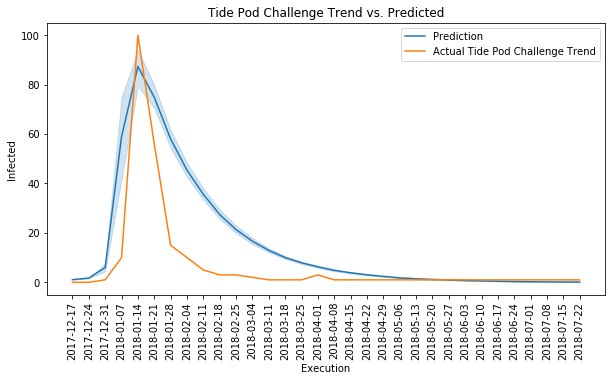

In [23]:
# Plot simulated results vs. actual Tide Pod Challenge Trend:
plt.figure(figsize=(10,5))
sns.lineplot(x='Execution', y='Infected', data=simulated_results_kiki, label='Prediction')
plt.plot(tide_pod_challenge, label='Actual Tide Pod Challenge Trend')
plt.xticks(rotation=90)
plt.title('Tide Pod Challenge Trend vs. Predicted')
plt.legend();

We can see that the model predicts the timing of the peak legisign replication well, but predicts a longer period of popularity after the peak than observed. We could potentially model this period of high legisign replication better using a model like Sprague and House's that incorporates two infected statuses "I" and "J" that transition by a time parameter $\epsilon$ (allowing us to better model the length of time at peak popularity). Ideally, we would also fit our model across a number of related social media trends to avoid biasing our prediction to much towards the Kiki Challenge data. It is also arguable that the replication of the Tide Pod Challenge legisign was artificially stopped short of its full potential, due to the influence of the trend particularly on children. After a certain point, Google and Facebook started removing videos that featured the challenge, and Proctor and Gamble (the makers of Tide Pods) changed their packaging, as well as introduced bitter tasting chemicals into the pod contents. Such an artifical stop to the trend would perhaps be better modeled with a higher probability of removal from the "infected" status, thus curtailing the long tail of the trend predicted from the Kiki Challenge.

Overall, though, this exercise demonstrates the general workflow you might pursue if you wanted to use a theory of legisign replication that you developed to predict future legisign replication processes. Such predictive modeling is certainly complicated by many different factors, but could provide a starting point for making projections in cultural trends.